In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_filter(image, kernel):
    img_height, img_width = image.shape
    k_height, k_width = kernel.shape
    
    pad_height = k_height // 2
    pad_width = k_width // 2
    
    padded_img = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='reflect')
    
    output = np.zeros_like(image, dtype=np.float32)
    
    for i in range(img_height):
        for j in range(img_width):
            region = padded_img[i:i+k_height, j:j+k_width]
            output[i, j] = np.sum(region * kernel)
            
    return output

def plot_image(points, width=500, height=500):
    img = np.zeros((height, width), dtype=np.uint8)
    
    for point_pair in points:
        pt1 = tuple(map(int, point_pair[0]))
        pt2 = tuple(map(int, point_pair[1]))
        cv2.line(img, pt1, pt2, 255, 2)
    
    contours = []
    current_point = points[0][0]
    contours.append(current_point)
    
    used_pairs = set()
    while len(contours) < len(points) + 1:
        for i, (p1, p2) in enumerate(points):
            if tuple(map(tuple, [p1, p2])) in used_pairs:
                continue
                
            if np.array_equal(p1, current_point):
                contours.append(p2)
                current_point = p2
                used_pairs.add(tuple(map(tuple, [p1, p2])))
                break
            elif np.array_equal(p2, current_point):
                contours.append(p1)
                current_point = p1
                used_pairs.add(tuple(map(tuple, [p1, p2])))
                break
    
    contours = np.array(contours, dtype=np.int32)
    
    cv2.fillPoly(img, [contours], 255)
    
    return img

def compute_gradient(image):
    
    kernel_x = np.array([[-1, 0, 1]], dtype=np.int8)
    kernel_y = kernel_x.T
    
    grad_x = apply_filter(image, kernel_x)
    grad_y = apply_filter(image, kernel_y)
    
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x)
    
    return magnitude, angle, grad_x, grad_y

def find_max_gradient_point(x, y, magnitude, window_size=2):
    max_mag = 0
    max_x, max_y = x, y
    
    for dx in range(-window_size, window_size + 1):
        for dy in range(-window_size, window_size + 1):
            new_x, new_y = x + dx, y + dy
            if (0 <= new_y < magnitude.shape[0] and 
                0 <= new_x < magnitude.shape[1] and 
                magnitude[new_y, new_x] > max_mag):
                max_mag = magnitude[new_y, new_x]
                max_x, max_y = new_x, new_y
    
    return max_x, max_y, max_mag

def draw_gradient_arrow(x, y, angle, color, arrow_length=30):
    dx = np.cos(angle) * arrow_length
    dy = np.sin(angle) * arrow_length
    plt.arrow(x, y, dx, dy, color=color, head_width=5, width=1, head_length=7)
    return dx, dy

def add_angle_text(x, y, angle_deg, dx, dy, color):
    angle_rad = np.radians(angle_deg)  # Dereceyi radyana çevir
    text_angle = angle_rad + (np.pi/4 if color == 'red' else -np.pi/4)
    text_distance = np.sqrt(dx**2 + dy**2) + 10
    text_x = x + text_distance * np.cos(text_angle)
    text_y = y + text_distance * np.sin(text_angle)
    
    plt.text(text_x, text_y, f'{angle_deg:.1f}°', 
            color=color, 
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            ha='center', 
            va='center')

def process_point(x, y, magnitude, angles, threshold, color):
    max_x, max_y, max_mag = find_max_gradient_point(x, y, magnitude)
    
    if max_mag > threshold:
        angle = angles[max_y, max_x]
        angle_deg = np.degrees(angle) % 360
        dx, dy = draw_gradient_arrow(max_x, max_y, angle, color)
        add_angle_text(max_x, max_y, angle_deg, dx, dy, color)

def draw_gradient_angles(image, angles, magnitude, points, threshold=10):
    plt.figure(figsize=(12, 12))
    plt.imshow(image, cmap='gray')

    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    
    for point_pair in points:
        pt1 = np.array(point_pair[0])
        pt2 = np.array(point_pair[1])
        
        for pt in [pt1, pt2]:
            process_point(int(pt[0]), int(pt[1]), magnitude, angles, threshold, 'red')
        
        mid_point = (pt1 + pt2) // 2
        process_point(int(mid_point[0]), int(mid_point[1]), magnitude, angles, threshold, 'blue')
    

    plt.title('Gradyan Açıları')
    plt.axis('equal')
    plt.show()

def draw_image(image):
    plt.figure(figsize=(12, 12))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


In [23]:
# Geometrik şekil tanımı
geometric_draw = [
    [(100, 100), (400,100)],
    [(100, 100), (200, 200)],
    [(100, 400), (200, 200)],
    [(100, 400), (400, 400)],
    [(400, 100), (400, 400)]
]

# Ana işlem akışı
img = plot_image(geometric_draw)
magnitude, angles, Gx, Gy = compute_gradient(img)



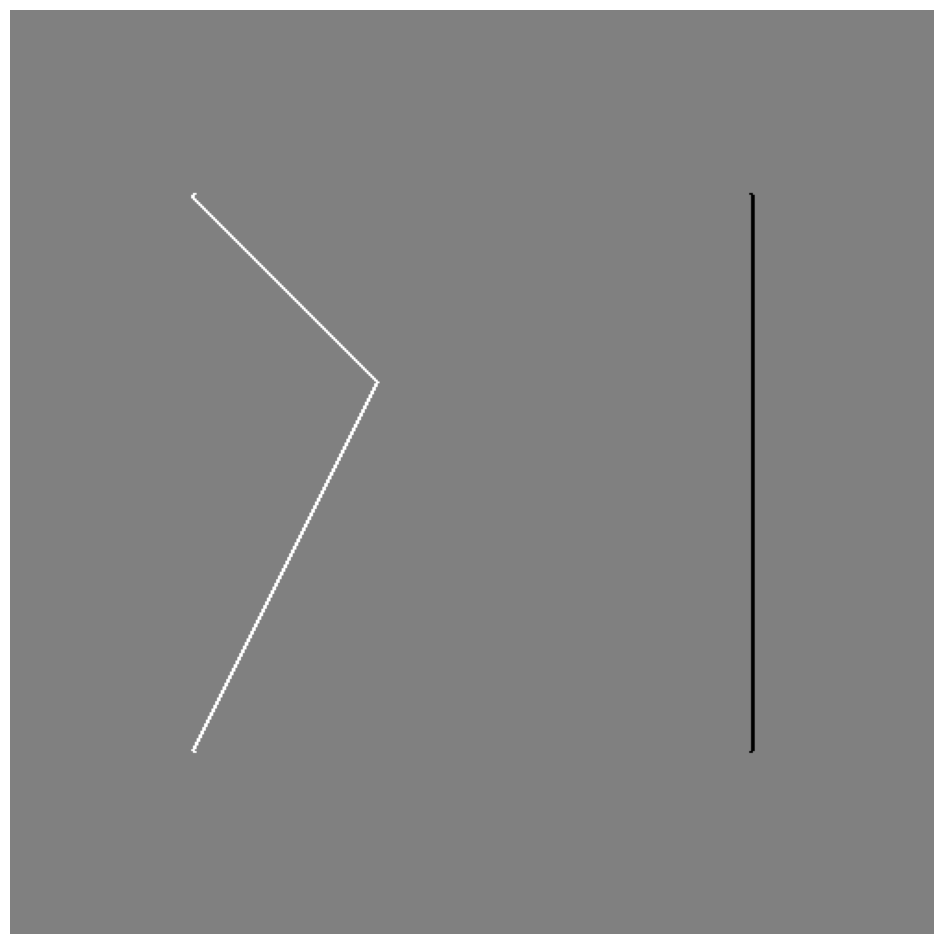

In [24]:
draw_image(Gx)

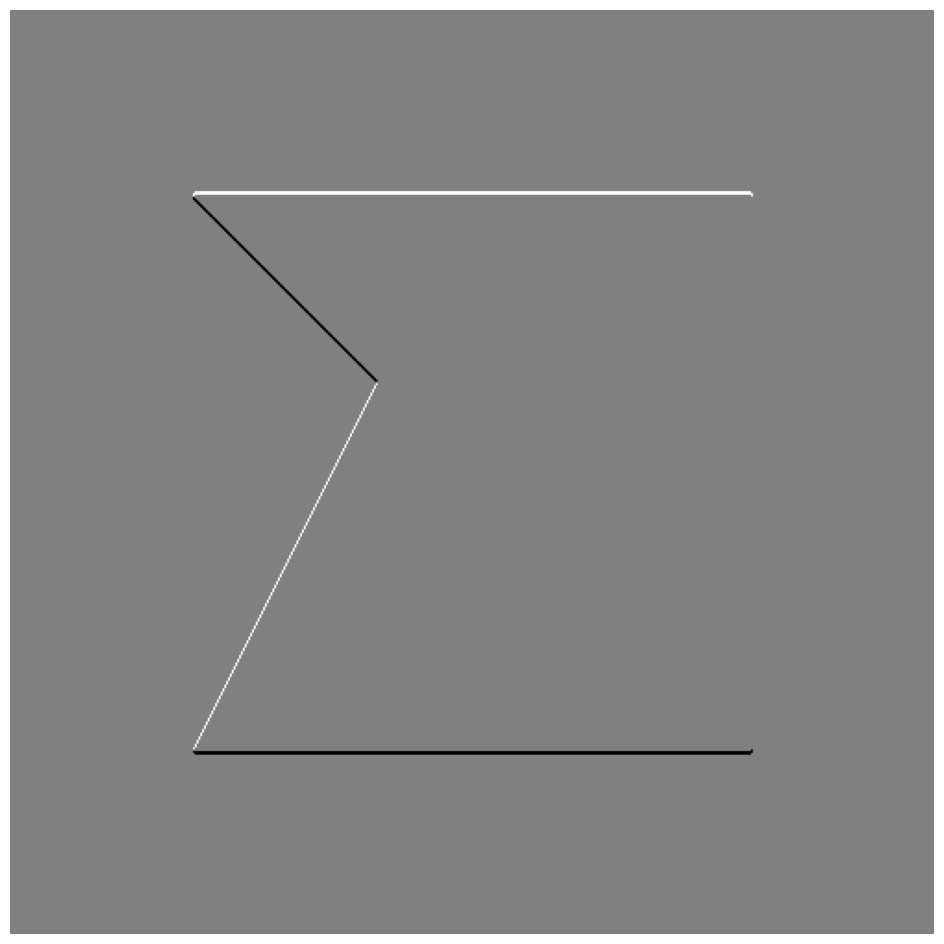

In [25]:
draw_image(Gy)

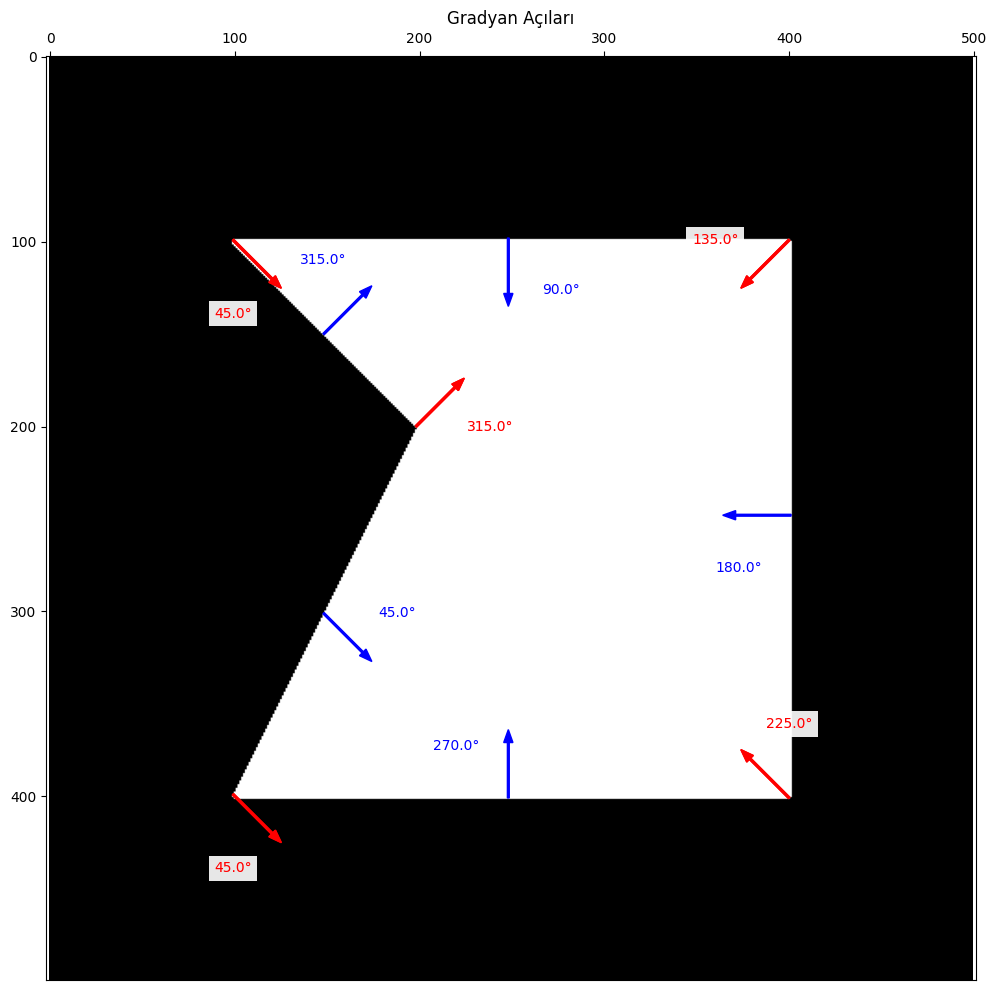

In [26]:
draw_gradient_angles(img, angles, magnitude, geometric_draw)


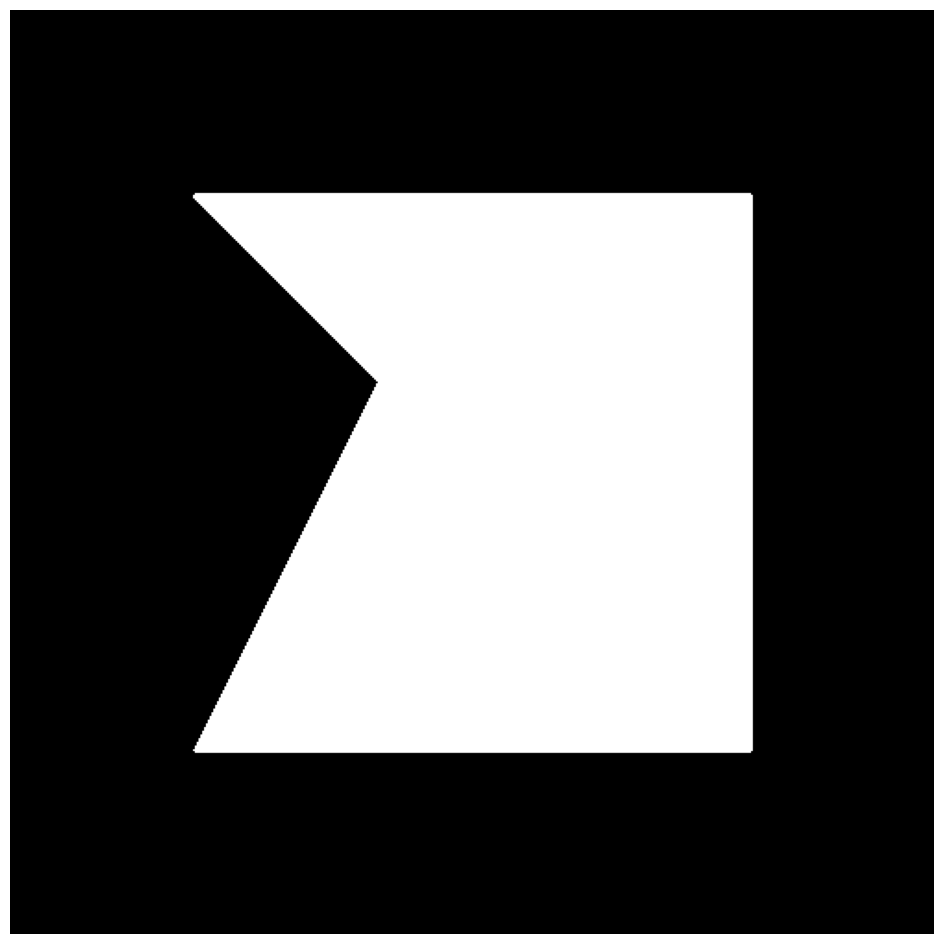

In [27]:
draw_image(img)